In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import cv2
from PIL import Image
from multiprocessing.pool import Pool

In [3]:
# Create array with all images
data_dir = 'kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/'
BATCH_SIZE = 64
from image_preprocessing import get_train_ds
IMG_SIZE = (150, 150)
dataset = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/train.csv').to_numpy()

In [4]:
from keras.applications import xception
xcept = xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=[IMG_SIZE[0], IMG_SIZE[1], 3],
    pooling='avg',
    classifier_activation="softmax",
)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
train_data = train_generator.flow_from_directory(r'D:\kaggle_ua\train_ds', 
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 subset="training"
                                                 )

Found 2360 images belonging to 6 classes.


In [7]:
from image_preprocessing import image_to_pose_cords

In [8]:
layer_output = xcept.layers[-21].output
feature_extractor = keras.Model(
    inputs=xcept.inputs,
    outputs=[layer_output]
)

In [9]:
def preprocess_image(img):
    cords = image_to_pose_cords(np.uint8(img))
    xcept_input = img.reshape((1, 150, 150, 3)) / 255
    vectors = feature_extractor.predict(xcept_input, verbose=0)[0]
    return cords, vectors

In [10]:
pose_cords = []
xcept_outputs = []
y_data = []
i = 0
for data, labels in train_data:
    if i % 10 == 0:
        print(i)
    i += 1
    for img in data:
        cords, vectors = preprocess_image(img)
        pose_cords.append(cords)
        xcept_outputs.append(vectors)
    for label in labels:
        y_data.append(label)
    if i == 128:
        break

0
10
20
30
40
50
60
70
80
90
100
110
120


In [11]:
X1 = np.array(pose_cords)
X2 = np.array(xcept_outputs)
Y = np.array(y_data)
np.save('np_arrays/x1.npy', X1)
np.save('np_arrays/x2.npy', X2)
np.save('np_arrays/Y.npy', Y)

In [12]:
X1 = np.load('np_arrays/x1.npy')
X2 = np.load('np_arrays/x2.npy')
Y = np.load('np_arrays/Y.npy')
print(X1.shape, X2.shape, Y.shape)

(4088, 33, 4) (4088, 9, 9, 728) (4088, 6)


In [13]:
def unison_shuffled_copies(x1, x2, y):
    assert len(x1) == len(x2)
    assert len(x2) == len(y)
    p = np.random.permutation(len(x1))
    return x1[p], x2[p], y[p]

shuffled_X1, shuffled_X2, shuffled_Y = unison_shuffled_copies(X1, X2, Y)

In [14]:
shuffled_X2.shape

(4088, 9, 9, 728)

In [15]:
X1_train = shuffled_X1[:2100, :, :]
X1_test = shuffled_X1[2100:, :, :]
X2_train = shuffled_X2[:2100, :]
X2_test = shuffled_X2[2100:, :]
Y_train = shuffled_Y[:2100, :]
Y_test = shuffled_Y[2100:, :]

# Model definition

In [16]:
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate

input_1 = tf.keras.layers.Input(shape=(33, 4, 1))
input_2 = tf.keras.layers.Input(shape=(9, 9, 728))

# Define the hidden layers
hidden_1 = Conv2D(64, (4, 4))(input_1)
# hidden_1 = Conv2D(128, (4, 1))(hidden_1)
hidden_1 = Flatten()(hidden_1)
hidden_1 = Dense(256, activation='relu')(hidden_1)
hidden_1 = Dense(256, activation='relu')(hidden_1)
# hidden_1 = Dense(256, activation='relu')(hidden_1)

hidden_2 = Conv2D(512, (3, 3))(input_2)
hidden_2 = MaxPooling2D(2, 2)(hidden_2)
hidden_2 = Flatten()(hidden_2)
# hidden_2 = Dense(1024, activation='relu')(hidden_2)
hidden_2 = Dense(512, activation='relu')(hidden_2)
# hidden_2 = Dense(1, activation='relu')(hidden_2)

# Concatenate the hidden layers
hidden = Concatenate()([hidden_1, hidden_2])
hidden = Dense(256, activation='relu')(hidden_1)
hidden = Dense(128, activation='relu')(hidden)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(6, activation='softmax')(hidden)

model = keras.Model(inputs=[input_1, input_2], outputs=output)

# Training the model

In [17]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('model.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [18]:
learning_rate = 3e-3
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=["accuracy"])

In [19]:
history = model.fit([X1_train, X2_train], Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=200,
                    validation_data=[[X1_test, X2_test], Y_test],
                    callbacks=[checkpoint,early_stop])

Epoch 1/200
33/33 [==============================] - ETA: 0s - loss: 1.7018 - accuracy: 0.2810
Epoch 1: val_accuracy improved from -inf to 0.32998, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 3s 63ms/step - loss: 1.7018 - accuracy: 0.2810 - val_loss: 1.6196 - val_accuracy: 0.3300
Epoch 2/200
27/33 [=======================>......] - ETA: 0s - loss: 1.5734 - accuracy: 0.3623
Epoch 2: val_accuracy improved from 0.32998 to 0.37525, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 41ms/step - loss: 1.5748 - accuracy: 0.3576 - val_loss: 1.5378 - val_accuracy: 0.3753
Epoch 3/200
29/33 [=========================>....] - ETA: 0s - loss: 1.5069 - accuracy: 0.4009
Epoch 3: val_accuracy improved from 0.37525 to 0.39386, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 2s 50ms/step - loss: 1.5017 - accuracy: 0.4010 - val_loss: 1.5295 - val_accuracy: 0.3939
Epoch 4/200
31/33 [===========================>..] - ETA: 0s - loss: 1.4250 - accuracy: 0.4390
Epoch 4: val_accuracy did not improve from 0.39386
33/33 [==============================] - 1s 15ms/step - loss: 1.4252 - accuracy: 0.4367 - val_loss: 1.5173 - val_accuracy: 0.3929
Epoch 5/200
33/33 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.4562
Epoch 5: val_accuracy improved from 0.39386 to 0.40191, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 42ms/step - loss: 1.3903 - accuracy: 0.4562 - val_loss: 1.4900 - val_accuracy: 0.4019
Epoch 6/200
33/33 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.4695
Epoch 6: val_accuracy improved from 0.40191 to 0.46529, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 44ms/step - loss: 1.3153 - accuracy: 0.4695 - val_loss: 1.3892 - val_accuracy: 0.4653
Epoch 7/200
33/33 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.5252
Epoch 7: val_accuracy improved from 0.46529 to 0.47686, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 42ms/step - loss: 1.2351 - accuracy: 0.5252 - val_loss: 1.3561 - val_accuracy: 0.4769
Epoch 8/200
31/33 [===========================>..] - ETA: 0s - loss: 1.2220 - accuracy: 0.5277
Epoch 8: val_accuracy improved from 0.47686 to 0.48541, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 46ms/step - loss: 1.2133 - accuracy: 0.5324 - val_loss: 1.4351 - val_accuracy: 0.4854
Epoch 9/200
33/33 [==============================] - ETA: 0s - loss: 1.1571 - accuracy: 0.5457
Epoch 9: val_accuracy improved from 0.48541 to 0.49044, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 2s 47ms/step - loss: 1.1571 - accuracy: 0.5457 - val_loss: 1.3495 - val_accuracy: 0.4904
Epoch 10/200
32/33 [============================>.] - ETA: 0s - loss: 1.1057 - accuracy: 0.5674
Epoch 10: val_accuracy did not improve from 0.49044
33/33 [==============================] - 0s 15ms/step - loss: 1.1082 - accuracy: 0.5657 - val_loss: 1.4246 - val_accuracy: 0.4774
Epoch 11/200
33/33 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.5776
Epoch 11: val_accuracy improved from 0.49044 to 0.49648, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 40ms/step - loss: 1.0924 - accuracy: 0.5776 - val_loss: 1.3531 - val_accuracy: 0.4965
Epoch 12/200
33/33 [==============================] - ETA: 0s - loss: 1.0483 - accuracy: 0.5933
Epoch 12: val_accuracy improved from 0.49648 to 0.50553, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 1s 41ms/step - loss: 1.0483 - accuracy: 0.5933 - val_loss: 1.4034 - val_accuracy: 0.5055
Epoch 13/200
29/33 [=========================>....] - ETA: 0s - loss: 0.9918 - accuracy: 0.6164
Epoch 13: val_accuracy did not improve from 0.50553
33/33 [==============================] - 1s 16ms/step - loss: 0.9989 - accuracy: 0.6090 - val_loss: 1.3918 - val_accuracy: 0.4925


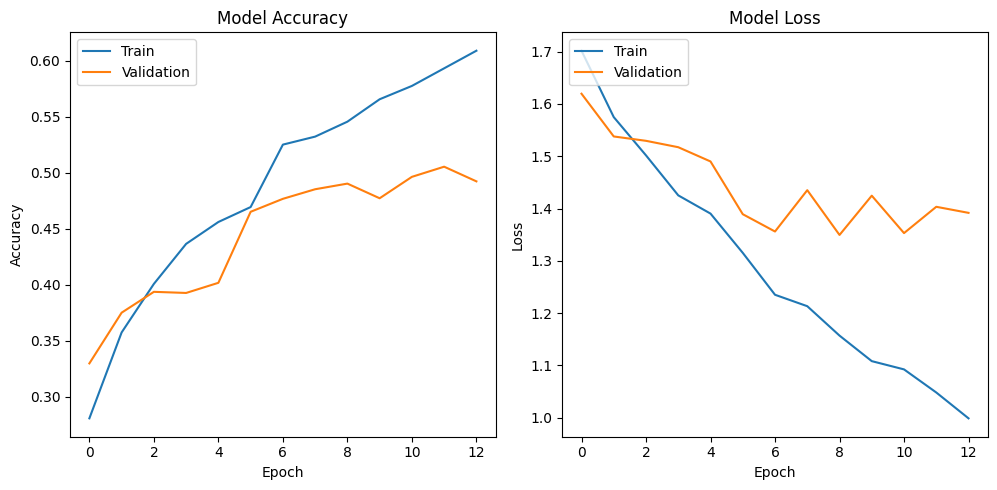

In [20]:
# Plot training & validation accuracy, F1 score, and loss values
plt.figure(figsize=(15, 5))

# Plotting Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Creating predictions submissions file

In [21]:
model.load_weights('model1111.h15')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model1111.h15

In [ ]:
from image_preprocessing import get_val_ds
# Load sample submission, change values to model forecasts
test_data_dir = 'kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/'

df = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv')
df_np = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv').to_numpy()
images = get_val_ds(df_np, test_data_dir, IMG_SIZE)

In [ ]:
for i, (name, cords) in enumerate(images):
    predictions = model.predict(np.array([cords]), verbose=0)[0]
    if i < 5:
        print(predictions)
    df.at[i,'class_6'] = np.argmax(predictions)

In [ ]:
df.to_csv('submission.csv', index=False)